# Newspaper Segmentation

Network backbone is a Resnet101

In [1]:
import os
import re
import sys
import cv2
import math
import json
import time
import random
import skimage
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Root directory of the project
ROOT_DIR = os.path.abspath("")
sys.path.append(ROOT_DIR)

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

MODEL_DIR = os.path.join(ROOT_DIR, "logs") # Directory to save logs and trained model
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5") # Local path to trained weights file

if not os.path.exists(COCO_MODEL_PATH): # Download COCO trained weights
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class ShapesConfig(Config):
    NAME = "newspapers"
    GPU_COUNT = 1 # Train on 1 GPU and 8 images per GPU.
    IMAGES_PER_GPU = 8 # Batch size is 8 (GPUs * images/GPU).
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    USE_MINI_MASK = False
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    
    LAYER_SELECT = '4+'
    LEARNING_RATE = 0.001
    EPOCHS = 100

    MAX_GT_INSTANCES = 25
    IMAGE_RESIZE_MODE = 'square' #square or pad64 or crop
    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels to extract low resolution 
    TRAIN_ROIS_PER_IMAGE = 25
    
    STEPS_PER_EPOCH = 100  # Use a small epoch since the data is simple
    VALIDATION_STEPS = 100 # use small validation steps since the epoch is small
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         100
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LAYER_SELECT                   all
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=12):
    """Return a Matplotlib Axes"""
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

* load_image()
* load_mask()
* image_reference()

In [4]:
class newspaperDataset(utils.Dataset):
    
    def load_data(self, dataset_dir, subset):
        """
        Load a subset of the newspaper dataset.
            
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """

        self.add_class("newspaper", 0, "article")
        self.add_class("newspaper", 1, "non-article")
        self.add_class("newspaper", 2, "title")

        assert subset in ["train", "test", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(dataset_dir, "annotations.json")))
        filenames = list(annotations.keys())
        annotations = list(annotations.values())

        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            shapes = [r['shape_attributes'] for r in a['regions'].values()]
            classes = [r['region_attributes']['label'] for r in a['regions'].values()]

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "newspaper",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                shapes=shapes,
                classes=classes)
            
        return filenames

    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        if image_info["source"] != "newspaper":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        classes = info['classes']
        
        mask = np.zeros([info["height"], info["width"], len(info["shapes"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["shapes"]):
            if p['name'] == 'polygon':
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                mask[rr, cc, i] = 1
                
            if p['name'] == 'rectangle':
                start = (int(p['ymin']),int(p['xmin']))
                extent = (int(p['ymax']),int(p['xmax']))
                
                rr, cc = skimage.draw.rectangle(start=start, extent=extent, shape=mask.shape)
                mask[rr, cc, i] = 1
                
        class_ids = np.array([self.class_names.index(s) for s in classes])
        
        return mask, class_ids
    
    def image_reference(self, image_id):

        info = self.image_info[image_id]
        if info["source"] == "newspaper":
            return info["newspaper"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [5]:
data_DIR = os.path.join(ROOT_DIR, "datasets/newspaper/")

dataset_train = newspaperDataset()
data_names_train = dataset_train.load_data(data_DIR, "train")
dataset_train.prepare()

In [6]:
data_DIR = os.path.join(ROOT_DIR, "datasets/newspaper/")

dataset_test = newspaperDataset()
data_names_test = dataset_test.load_data(data_DIR, "test")
dataset_test.prepare()

In [7]:
data_DIR = os.path.join(ROOT_DIR, "datasets/newspaper/")

dataset_val = newspaperDataset()
data_names_val = dataset_val.load_data(data_DIR, "val")
dataset_val.prepare()

In [8]:
print("Total images found in Training: ", len(dataset_train.image_ids))
print("Total images found in Validation: ", len(dataset_val.image_ids))
print("Total images found in Testing: ", len(dataset_test.image_ids))
print("\n")
print("Total images found in Dataset: ", len(dataset_train.image_ids)+len(dataset_val.image_ids)+len(dataset_test.image_ids))

Total images found in Training:  179
Total images found in Validation:  86
Total images found in Testing:  12


Total images found in Dataset:  277


### Useful functions

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)

In [11]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

Default GPU Device: /device:GPU:0


In [12]:
# tf.test.is_gpu_available(cuda_only=True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15990318774329977459
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2911292622
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11590685074023780365
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=config.EPOCHS, 
            layers=config.LAYER_SELECT)


Starting at epoch 0. LR=0.001

Checkpoint Path: f:\PROJECT\Newspaper_Segmentation\codes\02_modelling\logs\newspapers20220426T1835\mask_rcnn_newspapers_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res

In [15]:
%load_ext tensorboard

# %tensorboard --logdir logs/newspapers20220424T0201

In [16]:
model.load_weights(model_path, by_name=True)

NameError: name 'model_path' is not defined

In [17]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False
    DETECTION_MAX_INSTANCES = 25

inference_config = InferenceConfig()

# Recreate the model in inference mode
model_infer = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

model_path = model.find_last()

# model_path = os.path.join(r"logs\newspapers20220424T0201", "mask_rcnn_newspapers_0030.h5")

# model_path = os.path.join(r"logs\newspapers20220424T1546", "mask_rcnn_newspapers_0038.h5")

# Load trained weights
print("Loading weights from ", model_path)
model_infer.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Loading weights from  f:\PROJECT\Newspaper_Segmentation\codes\02_modelling\logs\newspapers20220426T1835\mask_rcnn_newspapers_0100.h5
Re-starting from epoch 100


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 6666.00000  float64
gt_class_id              shape: (8,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (8, 4)                min:    4.00000  max:  121.00000  int32
gt_mask                  shape: (128, 128, 8)         min:    0.00000  max:    1.00000  uint8


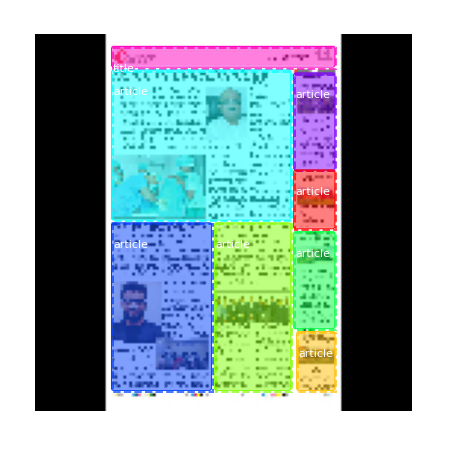

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
pred_class_id            shape: (25,)                 min:    1.00000  max:    2.00000  int32
pred_bbox                shape: (25, 4)               min:    0.00000  max:  128.00000  int32
pred_mask                shape: (128, 128, 25)        min:    0.00000  max:    1.00000  bool


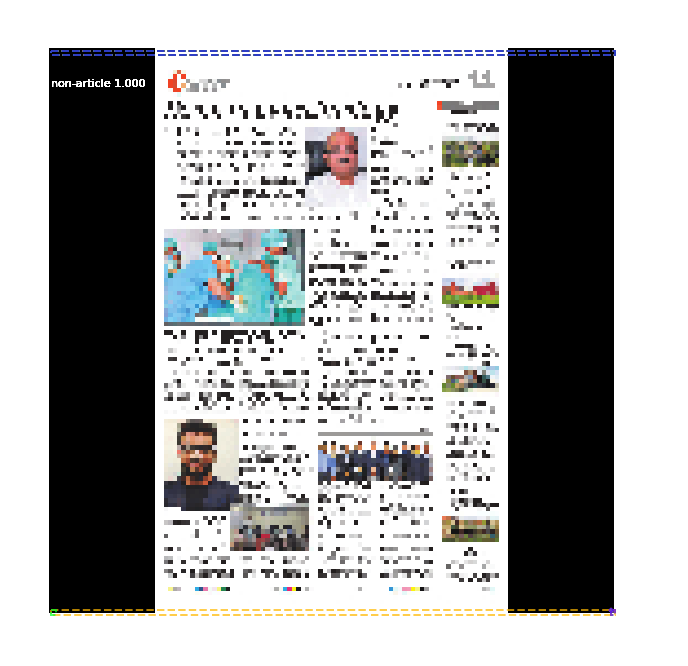

In [20]:
# Test on a random image
# image_id = random.choice(dataset_test.image_ids)

dataset_sel = dataset_train
image_id = random.choice(dataset_sel.image_ids)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_sel, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_sel.class_names, figsize=(8, 8))

results = model_infer.detect([original_image], verbose=1)

r = results[0]

log("pred_class_id", r['class_ids'])
log("pred_bbox", r['rois'])
log("pred_mask", r['masks'])
visualize.display_instances(original_image, r['rois'], r['masks'].astype(np.uint8), r['class_ids'], 
                            dataset_sel.class_names, r['scores'], ax=get_ax())

In [ ]:
gt_mask

In [ ]:
import numpy as np
r['masks'].astype(np.uint8)

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    original_image.shape, model.anchors, gt_class_id[1:4], gt_bbox[1:4], model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(original_image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())


In [ ]:
gt_class_id

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 14)
APs = []
Prec = []
Recall = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    Prec.append(np.mean(precisions))
    Recall.append(np.mean(recalls))
    
    
print("mAP: ", np.mean(APs))


In [ ]:
print("mPrec: ", np.mean(Prec))
print("mRecall: ", np.mean(Recall))

In [ ]:
APs

In [ ]:
Prec

In [ ]:
Recall

In [ ]:
None